## CSC14005 – MACHINE LEARNING
## FINAL PROJECT

## Sinh viên
- Lê Hoàng Sang - 21127158
- Trần Minh Quang - 21127407

## Thư viện

In [1]:
import fashion_mnist.utils.mnist_reader as mnist_reader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
X_train_org, y_train_org = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
X_test_org, y_test_org = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')

# image 28 * 28 = 784 pixel range from 0 to 255
# normalize the data to range 0 to 1
X_train_org = X_train_org / 255
X_test_org = X_test_org / 255
X_train_org.shape

(60000, 784)

In [3]:
y_train_org.shape

(60000,)

## Sử dụng PCA để giảm số chiều không gian dữ liệu

### Thuật toán PCA (Principal component analysis)

PCA (Principal Component Analysis) là một kỹ thuật phân tích đa biến được sử dụng trong xử lý dữ liệu và học máy để giảm kích thước của dữ liệu trong khi vẫn giữ được **thông tin quan trọng nhất**.

Trong bài toán của chúng ta không phải mọi điểm ảnh đều 'quan trọng' như nhau vì vậy để giảm thời gian trainning của thuật toán svm, nhóm em sẽ sử dụng PCA để giảm số pixel từ 784 xuống 100.

Ý tưởng của thuật toán PCA với hướng tiếp cận thông qua truncated svd<br>
1. Trước hết PCA sẽ sử tính toán ma trận hiệp phương sai (covariance matrix)
    - Ma trận hiệp phương sai là một ma trận vuông bán xác định dương với mọi phần tử hàng i cột j là hiệp phương sai của hai vector dữ liệu $x_i$ và $x_j$<br>
    Công thức tổng quát cho ma trận hiệp phương sai 
    $$
        A = cov(X, X) = \frac{1}{len(X)}(X - \bar{X})^T(X - \bar{X})
    $$
    Với $\bar{X}$ là ma trận với mỗi hàng chứa vector hàng m (mean) chứa các giá trị trung bình cho từng đặc trưng (từng pixel)
2. Sử dụng phép phân tích suy biến SVD để phân tích ma trận hiệp phương sai
    -  Phép phân tích SVD là phép phân rã ma trận thành tích của 3 ma trận, trong đó ma trận đầu là ma trận trực giao, ma trận giữa là ma trận đường chéo (chứa các trị riêng), ma trận cuối cũng là ma trận trực giao

    Tóm lại SVD đơn giản là phân tích **ma trận ban đầu** thành 3 ma trận
    $$
    A_{nn} = U_{nn}\sum_{nn}V_{nn}^T
    $$
    (Lưu ý công thức trên không phải là công thức tổng quát của svd với A vuông do A là ma trận hiệp phương sai)
3. Lấy ra các k **trị riêng lớn nhất** trong ma trận $\sum_{nn}$ để được ma trận $\sum _{kk}$, trị riêng càng lớn thì càng chưa nhiều thông tin của ma trận<br>
Một điều lưu ý là khi xây dựng $\sum$ trong phép phân tích svd người ta đã quy ước ma trận đường chéo của vector này sẽ chứa các trị riêng giảm dần vì vậy lấy ra các trị riêng lớn nhất là lấy các hàng các dòng đầu tiên<br>
<br>
Khi ta lấy lấy k trị riêng lớn nhất đồng nghĩa với việc hai ma trận U, V cũng phải giảm theo ta được $U_{nk}, V_{kn}$<br>
Ta sẽ phải lưu $V_{kn}$ cùng với vector m (mean) chứa các giá trị trung bình cho từng pixel để thực hiện việc ánh xạ dữ liệu sang không gian mới

4. Với mỗi dữ liệu truyền vào $X_{mn}$ ta sẽ được dữ liệu mới được tính bằng công thức
    $$
        X_{mk}^{new} = (X - M)_{mn}V_{kn}^T
    $$
    Với M là ma trận có kích thước bằng với ma trận X với các hàng là vector m chứa các giá trị trung bình cho từng đặc trưng (784 pixel)


    

In [4]:
# Create an instance of PCA
pca = PCA(n_components=0.95)

# Fit PCA on the training data
X_train_pca = pca.fit_transform(X_train_org)

# Transform the test data using the fitted PCA
X_test_pca = pca.transform(X_test_org)

X_train_pca.shape

(60000, 187)

In [5]:
# Khởi tạo để lưu model svm tốt nhất
best_model = None
best_val_err = 2
best_model_tranning_time = 0
best_model_name = None

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, y_train_org, test_size=0.2, random_state=42)
X_test, y_test = X_test_pca, y_test_org

### Using Linear Kernel

In [6]:
#linear model

err_linear_train = []
err_linear_val = []
training_time_linear = []

# Tạo danh sách các giá trị C bạn muốn thử nghiệm
# C_values = [0.1, 1.0, 7.0, 13, 50]
C_values = [0.01, 0.1, 1.0, 10, 50, 100]

for C in C_values:
    # Bắt đầu đo thời gian
    start_time = time.time()

    # Tạo và huấn luyện mô hình với giá trị C hiện tại
    model_linear = SVC(kernel='linear', C=C, decision_function_shape='ovo') #ovo one vs one
    model_linear.fit(X_train, y_train)

    # Đo thời gian huấn luyện
    training_time = time.time() - start_time

    # Tính độ lỗi trên tập huấn luyện
    start_time = time.time()    
    train_error = 1 - model_linear.score(X_train, y_train)

    # Tính độ lỗi trên tập validation
    val_error = 1 - model_linear.score(X_val, y_val)

    # Lưu lại độ lỗi của tập huấn luyện và tập validation
    err_linear_train.append(train_error)
    err_linear_val.append(val_error)

    # Lưu lại thời gian huấn luyện
    training_time_linear.append(training_time)

    if (val_error < best_val_err):
        best_val_err = val_error
        best_model = model_linear
        best_model_tranning_time = training_time
        best_model_name = 'linear C = ' + str(C)
    # In ra kết quả
    print(f"C={C} - Training Error: {train_error:.4f}, Validation Error: {val_error:.4f}, Training Time: {training_time:.2f} seconds, number of support vectors: {len(model_linear.support_vectors_)}")

C=0.01 - Training Error: 0.1344, Validation Error: 0.1421, Training Time: 100.91 seconds, number of support vectors: 18323
C=0.1 - Training Error: 0.1235, Validation Error: 0.1359, Training Time: 87.42 seconds, number of support vectors: 15634
C=1.0 - Training Error: 0.1187, Validation Error: 0.1398, Training Time: 135.42 seconds, number of support vectors: 14683
C=10 - Training Error: 0.1172, Validation Error: 0.1419, Training Time: 436.34 seconds, number of support vectors: 14474
C=50 - Training Error: 0.1167, Validation Error: 0.1437, Training Time: 1584.82 seconds, number of support vectors: 14397
C=100 - Training Error: 0.1165, Validation Error: 0.1432, Training Time: 3482.39 seconds, number of support vectors: 14393


### Using RBF Kernel

In [7]:
# RBF model

# Tạo danh sách các giá trị C và gamma bạn muốn thử nghiệm
# Như trên
C_values = [0.01, 0.1, 1.0, 10, 50, 100]

# auto  = 1/n_features
gamma_values = ['auto', 'scale', 0.001, 0.1]

err_rbf_train = [] # mảng 2 chiều mỗi dòng là một giá trị gamma, mỗi cột là một giá trị C
err_rbf_val = []
training_time_rbf = []

for gamma in gamma_values:
    err_rbf_train.append([])
    err_rbf_val.append([])
    training_time_rbf.append([])
    print('----------------------------------')
    print(f"Gamma={gamma}")

    for  C in C_values:
        # Bắt đầu đo thời gian
        start_time = time.time()

        # Tạo và huấn luyện mô hình với giá trị C và gamma hiện tại
        model_rbf = SVC(kernel='rbf', C=C, gamma=gamma,  decision_function_shape='ovo')
        model_rbf.fit(X_train, y_train)

        # Đo thời gian huấn luyện
        training_time = time.time() - start_time

        # Tính độ lỗi trên tập huấn luyện
        train_error = 1 - model_rbf.score(X_train, y_train)

        # Tính độ lỗi trên tập validation
        val_error = 1 - model_rbf.score(X_val, y_val)

        # Lưu lại độ lỗi của tập huấn luyện và tập validation
        err_rbf_train[-1].append(train_error)
        err_rbf_val[-1].append(val_error)
        
        # Lưu lại thời gian huấn luyện
        training_time_rbf[-1].append(training_time)

        if (val_error < best_val_err):
            best_val_err = val_error
            best_model = model_rbf
            best_model_tranning_time = training_time
            best_model_name = 'rbf C = ' + str(C) + ', gamma = ' + str(gamma)
        # In ra kết quả
        print(f"C={C}, gamma={gamma} - Training Error: {train_error:.4f}, Validation Error: {val_error:.4f}, Training Time: {training_time:.2f} seconds, number of support vectors: {len(model_rbf.support_vectors_)}")

----------------------------------
Gamma=auto


C=0.01, gamma=auto - Training Error: 0.2362, Validation Error: 0.2387, Training Time: 578.69 seconds, number of support vectors: 36436
C=0.1, gamma=auto - Training Error: 0.1631, Validation Error: 0.1670, Training Time: 215.14 seconds, number of support vectors: 24584
C=1.0, gamma=auto - Training Error: 0.1133, Validation Error: 0.1242, Training Time: 128.67 seconds, number of support vectors: 17872
C=10, gamma=auto - Training Error: 0.0734, Validation Error: 0.1025, Training Time: 107.94 seconds, number of support vectors: 14522
C=50, gamma=auto - Training Error: 0.0383, Validation Error: 0.0978, Training Time: 94.33 seconds, number of support vectors: 13627
C=100, gamma=auto - Training Error: 0.0243, Validation Error: 0.0968, Training Time: 88.51 seconds, number of support vectors: 13627
----------------------------------
Gamma=scale
C=0.01, gamma=scale - Training Error: 0.2119, Validation Error: 0.2147, Training Time: 349.04 seconds, number of support vectors: 33393
C=0.1, gamma=sca

### Comment results

#### Training error

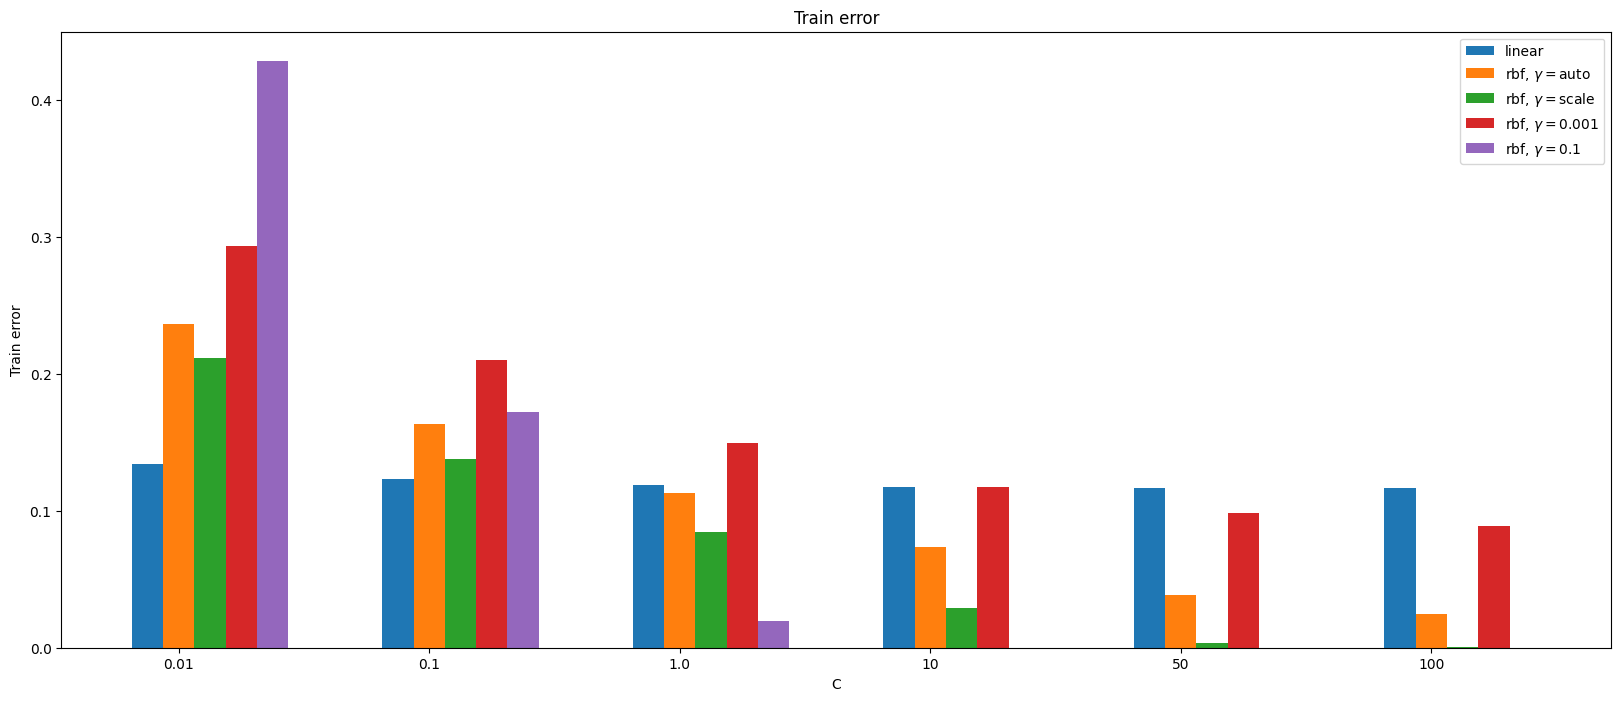

In [8]:
plt.figure(figsize=(20, 8))

C_values_str = list(map(str, C_values))

ind =  np.arange(len(C_values))
ind = ind*2
width = 0.25

plt.bar(ind, err_linear_train, width = width,label=r'linear')

for i in range(len(gamma_values)):
    plt.bar(ind + width*(i + 1), err_rbf_train[i],label=r'rbf, $\gamma=$'+str(gamma_values[i]), width=width)

plt.title('Train error')
plt.xlabel('C')
plt.ylabel('Train error')
plt.xticks(ind + width, np.array(C_values_str))
plt.legend()
plt.show()

#### Validation error

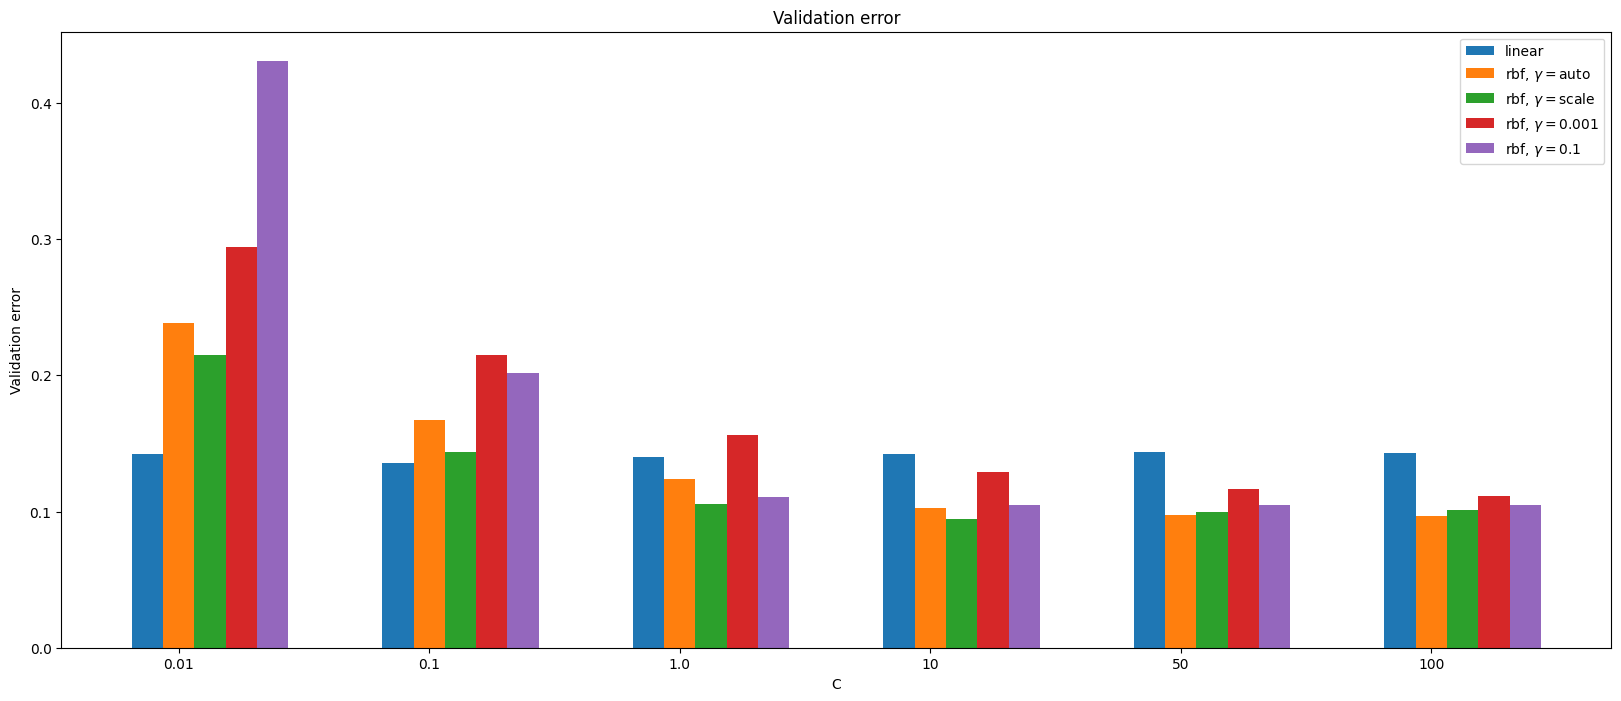

In [9]:
plt.figure(figsize=(20, 8))

C_values_str = list(map(str, C_values))

ind =  np.arange(len(C_values))
ind = ind*2
width = 0.25

plt.bar(ind, err_linear_val, width = width,label=r'linear')

for i in range(len(gamma_values)):
    plt.bar(ind + width*(i + 1), err_rbf_val[i],label=r'rbf, $\gamma=$'+str(gamma_values[i]), width=width)

plt.title('Validation error')
plt.xlabel('C')
plt.ylabel('Validation error')
plt.xticks(ind + width, np.array(C_values_str))
plt.legend()
plt.show()

#### Tranning time

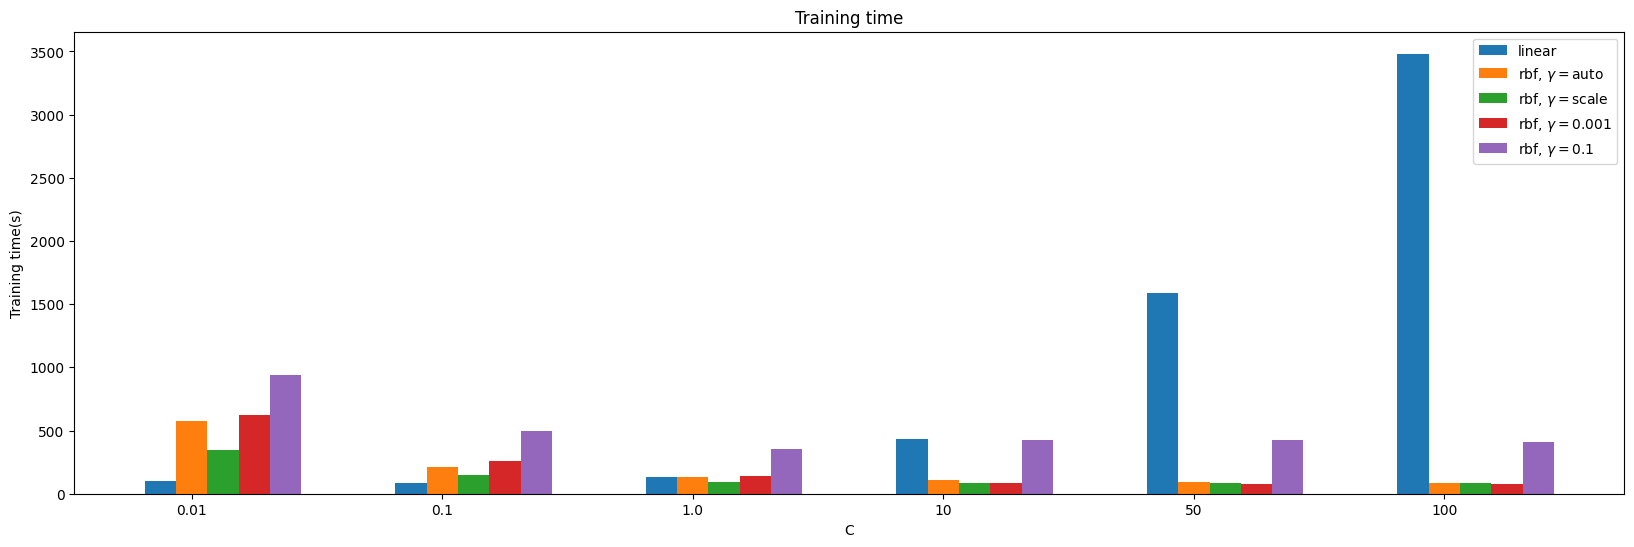

In [10]:
plt.figure(figsize=(20, 6))

C_values_str = list(map(str, C_values))

ind =  np.arange(len(C_values))
ind = ind*2
width = 0.25

plt.bar(ind, training_time_linear, width = width,label=r'linear')

for i in range(len(gamma_values)):
    plt.bar(ind + width*(i + 1), training_time_rbf[i],label=r'rbf, $\gamma=$'+str(gamma_values[i]), width=width)

plt.title('Training time')
plt.xlabel('C')
plt.ylabel('Training time(s)')
plt.xticks(ind + width, np.array(C_values_str))
plt.legend()
plt.show()

### Review SVM


In [11]:
print('Best model: ', best_model_name)
print('Best validation error: ', best_val_err)

svm_preidct = best_model.predict(X_test)
print(classification_report(y_test, svm_preidct))
svm_accuracy = accuracy_score(y_test, svm_preidct)

Best model:  rbf C = 10, gamma = scale
Best validation error:  0.09475
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.83      0.83      0.83      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.71      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [13]:
train_time_other_model = [best_model_tranning_time]
val_error_other_model = [best_val_err]
test_accuracy_other_model = [svm_accuracy]

# Logistic Regression
logreg = LogisticRegression(max_iter=400)

# Fit the model on the training data
start_time_logreg = time.time()
logreg.fit(X_train, y_train)
train_time_other_model.append(time.time() - start_time_logreg)

# validation
logreg_pred = logreg.predict(X_val)
val_error_other_model.append(1 - accuracy_score(y_val, logreg_pred))

# Test
logreg_pred = logreg.predict(X_test)
test_accuracy_other_model.append(accuracy_score(y_test, logreg_pred))

#----------------
# Neural Network
nn = MLPClassifier(hidden_layer_sizes=(100, 50), activation='logistic', batch_size=32)

start_time_nn = time.time()
nn.fit(X_train, y_train)
train_time_other_model.append(time.time() - start_time_nn)

# validation
nn_pred = nn.predict(X_val)
val_error_other_model.append(1 - accuracy_score(y_val, nn_pred))

# Test
nn_pred = nn.predict(X_test)
test_accuracy_other_model.append(accuracy_score(y_test, nn_pred))

c:\Users\nq201\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
model = ['SVM', 'Logistic Regression', 'Neural Network']
for i in range(len(model)):
    print(model[i])
    print('Training time: ', train_time_other_model[i])
    print('Validation error: ', val_error_other_model[i])
    print('Accuracy on test set: ', test_accuracy_other_model[i])
    print('-----------------------------')

SVM
Training time:  86.76718354225159
Validation error:  0.09475
Accuracy on test set:  0.8993
-----------------------------
Logistic Regression
Training time:  26.608466863632202
Validation error:  0.14649999999999996
Accuracy on test set:  0.8421
-----------------------------
Neural Network
Training time:  398.10174655914307
Validation error:  0.132
Accuracy on test set:  0.8658
-----------------------------


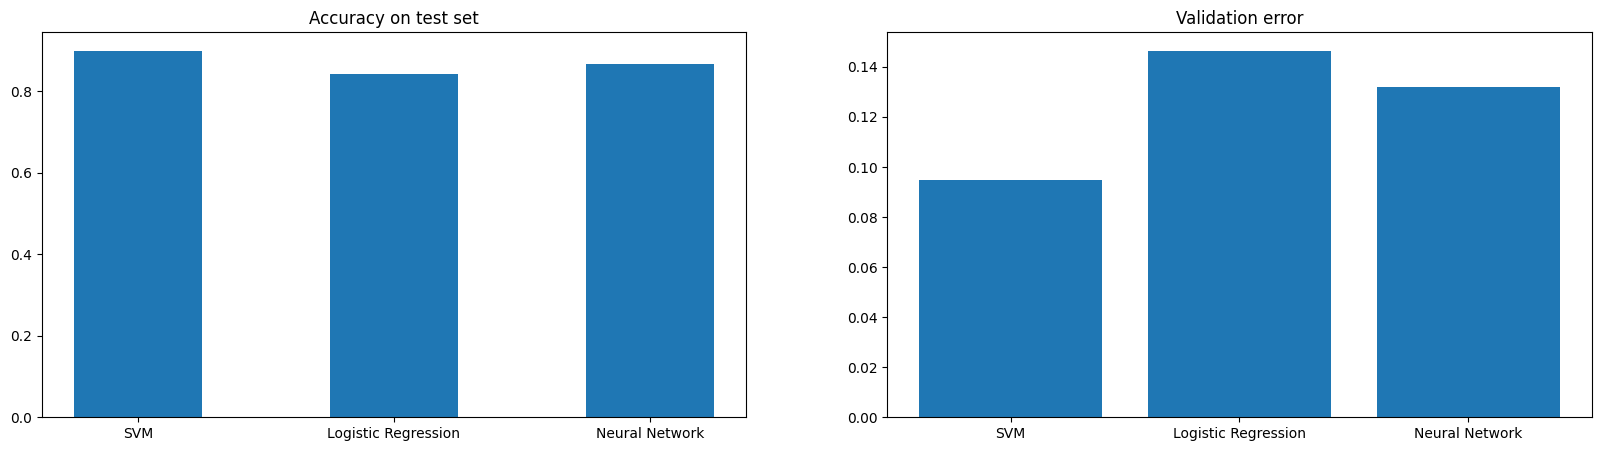

In [17]:
fig, axes =  plt.subplots(1, 2,figsize=(20, 5))

axes[0].bar(['SVM', 'Logistic Regression', 'Neural Network'], test_accuracy_other_model, width=0.5)
axes[0].set_title('Accuracy on test set')

axes[1].bar(['SVM', 'Logistic Regression', 'Neural Network'], val_error_other_model)
axes[1].set_title('Validation error')

plt.show()

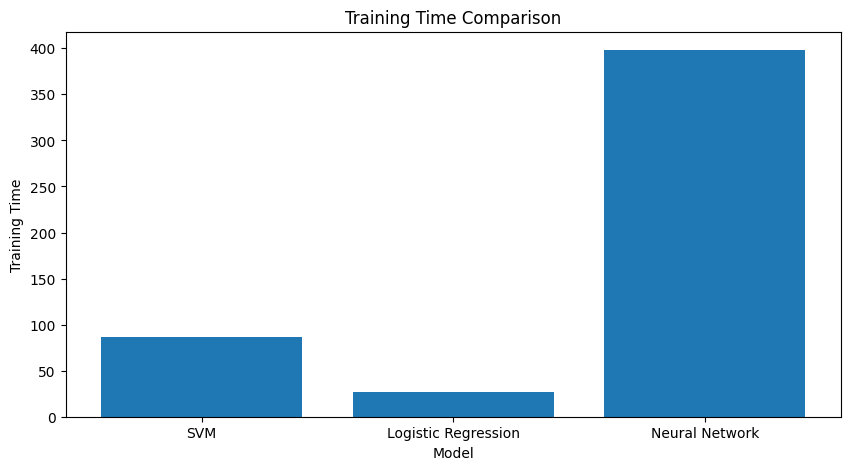

In [18]:
# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(['SVM', 'Logistic Regression', 'Neural Network'], train_time_other_model)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Training Time')
plt.title('Training Time Comparison')

# Display the plot
plt.show()

In [19]:
print('Predict time SVM')
start_time = time.time()
svm_preidct = best_model.predict(X_test)
print('Time predict: ', time.time() - start_time)
print()

print('Predict time Nerual Network')
start_time = time.time()
nn_pred = nn.predict(X_test)
print('Time predict: ', time.time() - start_time)
print()

print('Predict time Logistic Regression')
start_time = time.time()
logreg_pred = logreg.predict(X_test)
print('Time predict: ', time.time() - start_time)
print()

Predict time SVM
Time predict:  39.280038595199585

Predict time Nerual Network
Time predict:  0.08422660827636719

Predict time Logistic Regression
Time predict:  0.006978750228881836

